In [2]:
import qiskit
import qiskit.quantum_info
import qiskit.visualization

import quantum_f
import qCounters

# Creación del oráculo para el grafo de 6 nodos, JISBD 2025

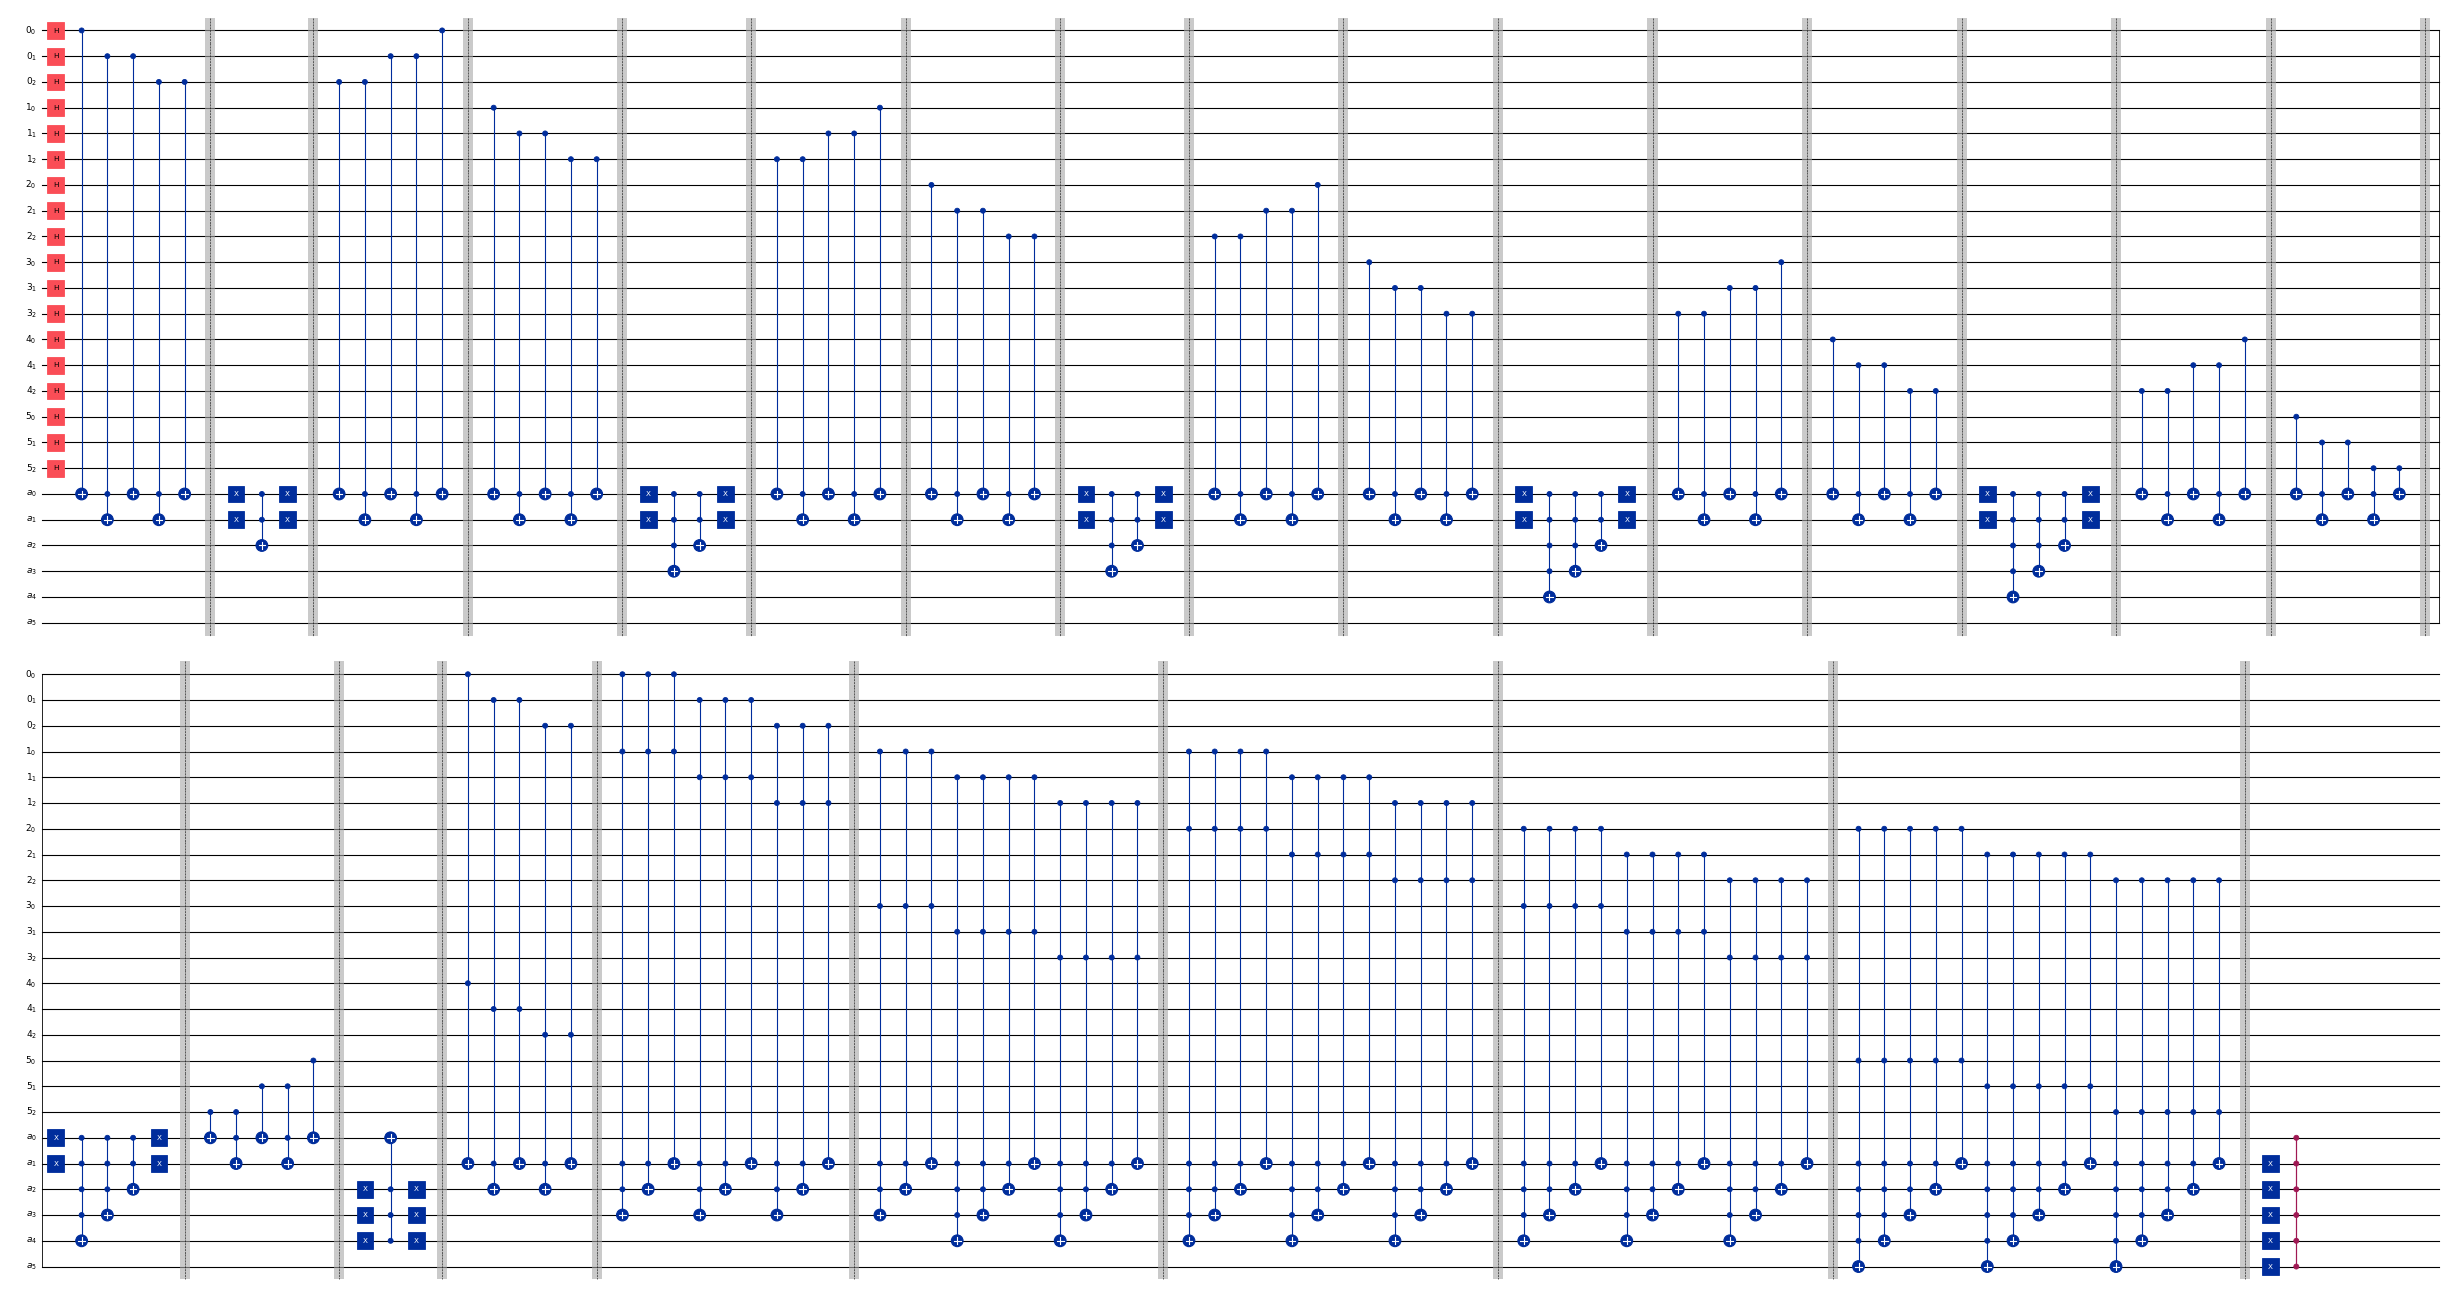

In [3]:
def f_condicion1 (oracle, nodo0, nodo1, nodo2, nodo3, nodo4, nodo5, ancillas):
    tmp=oracle.copy_empty_like()
    cnt_c2 = qCounters.C_Counter(ancillas[:2], ancillas[2:5], tmp)
    for nodo in [nodo0, nodo1, nodo2, nodo3, nodo4, nodo5]:
        cnt_c1=qCounters.C_Ladder_Counter([nodo], ancillas[:2], tmp)
        while not cnt_c1.is_exhausted():
            tmp.compose(cnt_c1.next(), inplace=True)
        oracle.compose(tmp, inplace=True)
        oracle.barrier()
        oracle.x(ancillas[:2])
        oracle.compose(cnt_c2.next(), inplace=True)
        oracle.x(ancillas[:2])
        oracle.barrier()
        oracle.compose(tmp.reverse_ops(), inplace=True)
        oracle.barrier()
        tmp.clear()     

    oracle.x(ancillas[2:5])
    oracle.mcx(ancillas[2:5], ancillas[0])
    oracle.x(ancillas[2:5])
    oracle.barrier()  
    return oracle


def f_condicion2(oracle, nodo0, nodo1, nodo2, nodo3, nodo4, nodo5, ancillas):
    tmp=oracle.copy_empty_like()
    ultimo_valor=0
    aristas=[(nodo4, nodo0), (nodo0, nodo1), (nodo1, nodo3), (nodo1, nodo2), (nodo2, nodo3), (nodo2, nodo5)]
    for a in aristas:
        cnt = qCounters.C_Ladder_Counter ([a[0], a[1]], ancillas[1:6], tmp, ultimo_valor)
        while not cnt.is_exhausted():
            tmp.compose(cnt.next(), inplace=True)
        ultimo_valor = cnt.get_count_value()
        oracle.compose(tmp, inplace=True)
        oracle.barrier()
        tmp.clear()   
    oracle.x(ancillas[1:6])
    return oracle

nodo0=qiskit.circuit.QuantumRegister(3, '0')
nodo1=qiskit.circuit.QuantumRegister(3, '1')
nodo2=qiskit.circuit.QuantumRegister(3, '2')
nodo3=qiskit.circuit.QuantumRegister(3, '3')
nodo4=qiskit.circuit.QuantumRegister(3, '4')
nodo5=qiskit.circuit.QuantumRegister(3, '5')
ancillas=qiskit.circuit.AncillaRegister(6, 'a') 

circuito = qiskit.QuantumCircuit(nodo0, nodo1, nodo2, nodo3, nodo4, nodo5, ancillas)

oracle=circuito.copy_empty_like()
oracle_c2=circuito.copy_empty_like()
f_condicion1(oracle, nodo0, nodo1, nodo2, nodo3, nodo4, nodo5, ancillas)
f_condicion2(oracle_c2, nodo0, nodo1, nodo2, nodo3, nodo4, nodo5, ancillas)
oracle.compose(oracle_c2,inplace=True)
oracle_undo=oracle.copy().reverse_ops()
quantum_f.phase_and(oracle, [ancillas[0], *ancillas[1:6]])

for j in [nodo0, nodo1, nodo2, nodo3, nodo4, nodo5]:    circuito.h(j)
circuito.compose(oracle, inplace=True)

circuito.draw(output="mpl", scale=0.4, fold=93)


In [4]:
print(f"Profundidad circuito: {circuito.depth()}") 
print(f"Número de puertas: {circuito.size()}")

basis_gates = ['sx', 'x', 'rz', 'ecr'] # IBM Eagle Quantum Processor native gates

pass_manager = qiskit.transpiler.PassManager()
pass_manager.append(qiskit.transpiler.passes.UnrollCustomDefinitions(qiskit.circuit.equivalence_library.SessionEquivalenceLibrary, basis_gates))
pass_manager.append(qiskit.transpiler.passes.BasisTranslator(qiskit.circuit.equivalence_library.SessionEquivalenceLibrary, basis_gates))

transpiled_circuit2 = pass_manager.run(circuito)
print(f"Número de puertas transpilado: {transpiled_circuit2.size()}")
print(f"Profundidad del circuito transpilado: {transpiled_circuit2.depth()}")
print(f"Número de puertas ECR: {transpiled_circuit2.count_ops().get('ecr', 0)}")
print(f"Número de puertas SX: {transpiled_circuit2.count_ops().get('sx', 0)}")


Profundidad circuito: 156
Número de puertas: 193
Número de puertas transpilado: 28207
Profundidad del circuito transpilado: 16155
Número de puertas ECR: 2722
Número de puertas SX: 4038


# Adición de 35 iteraciones Grover 
Puesto que el grafo de las JISBD tiene 126 soluciones (contando múltiples opciones de coloreado), el numero de iteraciones Grover es 35

In [5]:
oracle.compose(oracle_undo, inplace=True)
circuito.compose(oracle_undo, inplace=True)
oracle.barrier()
circuito.barrier()
quantum_f.add_diffuser(oracle, quantum_f.flatten_list([nodo0, nodo1, nodo2, nodo3, nodo4, nodo5]))
quantum_f.add_diffuser(circuito, quantum_f.flatten_list([nodo0, nodo1, nodo2, nodo3, nodo4, nodo5]))

for i in range (35):
    circuito.compose(oracle, inplace=True)

#circuito.draw(output="mpl", scale=0.4, fold=93)

In [6]:
print(f"Profundidad circuito: {circuito.depth()}") 
print(f"Número de puertas: {circuito.size()}")

transpiled_circuit35 = pass_manager.run(circuito)
print(f"Número de puertas transpilado: {transpiled_circuit35.size()}")
print(f"Profundidad del circuito transpilado: {transpiled_circuit35.depth()}")
print(f"Número de puertas ECR: {transpiled_circuit35.count_ops().get('ecr', 0)}")
print(f"Número de puertas SX: {transpiled_circuit35.count_ops().get('sx', 0)}")

Profundidad circuito: 11305
Número de puertas: 15210
Número de puertas transpilado: 2768094
Profundidad del circuito transpilado: 1661333
Número de puertas ECR: 264240
Número de puertas SX: 416466


## Simulación del circuito completo e impresión de soluciones

In [7]:
st35its = qiskit.quantum_info.Statevector(circuito)

In [8]:
[max_prob, combs] = quantum_f.max_prob_combinations(st35its)
print("Max prob: ", max_prob*100, "%\nCombinations:")
for i in combs:
    print("|",i,"\u232A", sep='')

print(f"Num valores:", len(combs))

Max prob:  0.7929477491918616 %
Combinations:
|000000001001001010100010〉
|000000001001001100010100〉
|000000001001010100001010〉
|000000001001010100001100〉
|000000001001010100001110〉
|000000001001100010001010〉
|000000001001100010001100〉
|000000001001100010001110〉
|000000001010001010100001〉
|000000001010001100010001〉
|000000001010001100010100〉
|000000001010001100010101〉
|000000001010010100001100〉
|000000001010100010001100〉
|000000001011001100010100〉
|000000001011010100001100〉
|000000001011100010001100〉
|000000001100001010100001〉
|000000001100001010100010〉
|000000001100001010100011〉
|000000001100001100010001〉
|000000001100010100001010〉
|000000001100100010001010〉
|000000001101001010100010〉
|000000001101010100001010〉
|000000001101100010001010〉
|000000001110001010100001〉
|000000001110001100010001〉
|000000010001001100010100〉
|000000010001010001100010〉
|000000010001010100001010〉
|000000010001010100001100〉
|000000010001010100001110〉
|000000010001100001010100〉
|000000010010001100010001〉
|00000001

In [9]:
print(f"Num valores:", len(combs))

Num valores: 126
